# Anomaly Detection with Isolation Forests using H2O

## Introduction

Anomaly detection is a common data science problem where the goal is to identify odd or suspicious observations, events, or items in our data that might be indicative of some issues in our data collection process (such as broken sensors, typos in collected forms, etc.) or unexpected events like security breaches, server failures, and so on. 

Anomaly detection can be performed in a supervised, semi-supervised, and unsupervised manner.

For a supervised approach, we need to know whether each observation, event or item is anomalous or genuine, and we use this information during training. Obtaining labels for each observation might often be unrealistic.

A semi-supervised approach uses the assumption that we only know which observations are genuine, non-anomalous, and we do not have any information on the anomalous observations. Therefore we only use the genuine data for training. During prediction, the model evaluates how similar the new observation is to the training data and how well it fits the model. 

An unsupervised approach assumes that the training set contains both genuine and anomalous observations. As labeling the data or having just clean data is often hard and time consuming, I would like to focus more on one of the unsupervised approaches to anomaly detection using isolation forests.


## Loading the Data

Before we dive into the anomaly detection, let's initialize the h2o cluster and load our data in. We will be using the [credit card data set](https://www.kaggle.com/mlg-ulb/creditcardfraud), which contains information on various properties of credit card transactions. There are 492 fraudulent and 284,807 genuine transactions, which makes the target class highly imbalanced. We will not use the label during the anomaly detection modeling, but we will use it during the evaluation of our anomaly detection.

In [1]:
import h2o
h2o.init()

df = h2o.import_file("creditcard.csv")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_181"; Java(TM) SE Runtime Environment (build 1.8.0_181-b13); Java HotSpot(TM) 64-Bit Server VM (build 25.181-b13, mixed mode)
  Starting server from /Users/martin/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/y9/068gjw8x6h1dx030sdstgv_00000gn/T/tmpq1q8f7pf
  JVM stdout: /var/folders/y9/068gjw8x6h1dx030sdstgv_00000gn/T/tmpq1q8f7pf/h2o_martin_started_from_python.out
  JVM stderr: /var/folders/y9/068gjw8x6h1dx030sdstgv_00000gn/T/tmpq1q8f7pf/h2o_martin_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Prague
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.1
H2O cluster version age:,6 days
H2O cluster name:,H2O_from_python_martin_9es8ho
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,0
H2O cluster allowed cores:,0
H2O cluster status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%


## Isolation Forests

There are multiple approaches to an unsupervised anomaly detection problem that try to exploit the differences between the properties of common and unique observations. The idea behind the [Isolation Forest](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf) is as follows.

* We start by building multiple decision trees such that the trees isolate the observations in their leaves. Ideally, each leaf of the tree isolates exactly one observation from your data set. The trees are being split randomly. We assume that if one observation is similar to others in our data set, it will take more random splits to perfectly isolate this observation, as opposed to isolating an outlier.

* For an outlier that has some feature values significantly different from the other observations, randomly finding the split isolating it should not be too hard. As we build multiple isolation trees, hence the isolation forest, for each observation we can calculate the average number of splits across all the trees that isolate the observation. The average number of splits is then used as a score, where the less splits the observation needs, the more likely it is to be anomalous. 

Let's train our isolation forest and see how the predictions look. The last column (index 30) of the data contains the class label, so we exclude it from the training process.

In [2]:
seed = 12345
ntrees = 100
isoforest = h2o.estimators.H2OIsolationForestEstimator(
    ntrees=ntrees, seed=seed)
isoforest.train(x=df.col_names[0:31], training_frame=df)
predictions = isoforest.predict(df)

predictions

isolationforest Model Build progress: |███████████████████████████████████| 100%
isolationforest prediction progress: |████████████████████████████████████| 100%


predict,mean_length
0.0284238,6.82
-0.00258398,6.94
0.0956072,6.56
0.0568475,6.71
0.00775194,6.9
0,6.93
0.0155039,6.87
0.20155,6.15
0.0413437,6.77
0.00258398,6.92



## Inspecting Predictions
We can see that the prediction h2o frame contains two columns: **predict** showing a normalized anomaly score, and **mean_length** showing the average number of splits across all trees to isolate the observation.

These two columns should have the property of inverse proportion by their definition, as the less random splits you need to isolate the observation, the more anomalous it is. We can easily check that.

In [3]:
predictions.cor()

predict,mean_length
1,-1
-1,1


## Predicting Anomalies using Quantile

As we formulated this problem in an unsupervised fashion, how do we go from the average number of splits / anomaly score to the actual predictions? Using a threshold! If we have an idea about the relative number of outliers in our dataset, we can find the corresponding quantile value of the score and use it as a threshold for our predictions.

In [4]:
quantile = 0.95
quantile_frame = predictions.quantile([quantile])
quantile_frame

Probs,predictQuantiles,mean_lengthQuantiles
0.95,0.165375,6.99


We can use the threshold to predict the anomalous class.

In [5]:
threshold = quantile_frame[0, "predictQuantiles"]
predictions["predicted_class"] = predictions["predict"] > threshold
predictions["class"] = df["Class"]
predictions

predict,mean_length,predicted_class,class
0.0284238,6.82,0,0
-0.00258398,6.94,0,0
0.0956072,6.56,0,0
0.0568475,6.71,0,0
0.00775194,6.9,0,0
0,6.93,0,0
0.0155039,6.87,0,0
0.20155,6.15,1,0
0.0413437,6.77,0,0
0.00258398,6.92,0,0


## Evaluation

Because the isolation forest is an unsupervised method, it makes sense to have a look at the classification metrics that are not dependent on the prediction threshold and give an estimate of the quality of scoring. Two such metrics are Area Under the Receiver Operating Characteristic Curve (AUC) and Area under the Precision-Recall Curve (AUCPR).

AUC is a metric evaluating how well a binary classification model distinguishes true positives from false positives. The perfect AUC score is 1; the baseline score of a random guessing is 0.5.

AUCPR is a metric evaluating the precision recall trade-off of a binary classification using different thresholds of the continuous prediction score. The perfect AUCPR score is 1; the baseline score is the relative count of the positive class.  

For highly imbalanced data, AUCPR is recommended over AUC as the AUCPR is more sensitive to True positives, False positives and False negatives, while not caring about True negatives, which in large quantity usually overshadow the effect of other metrics.

<IPython.core.display.Javascript object>


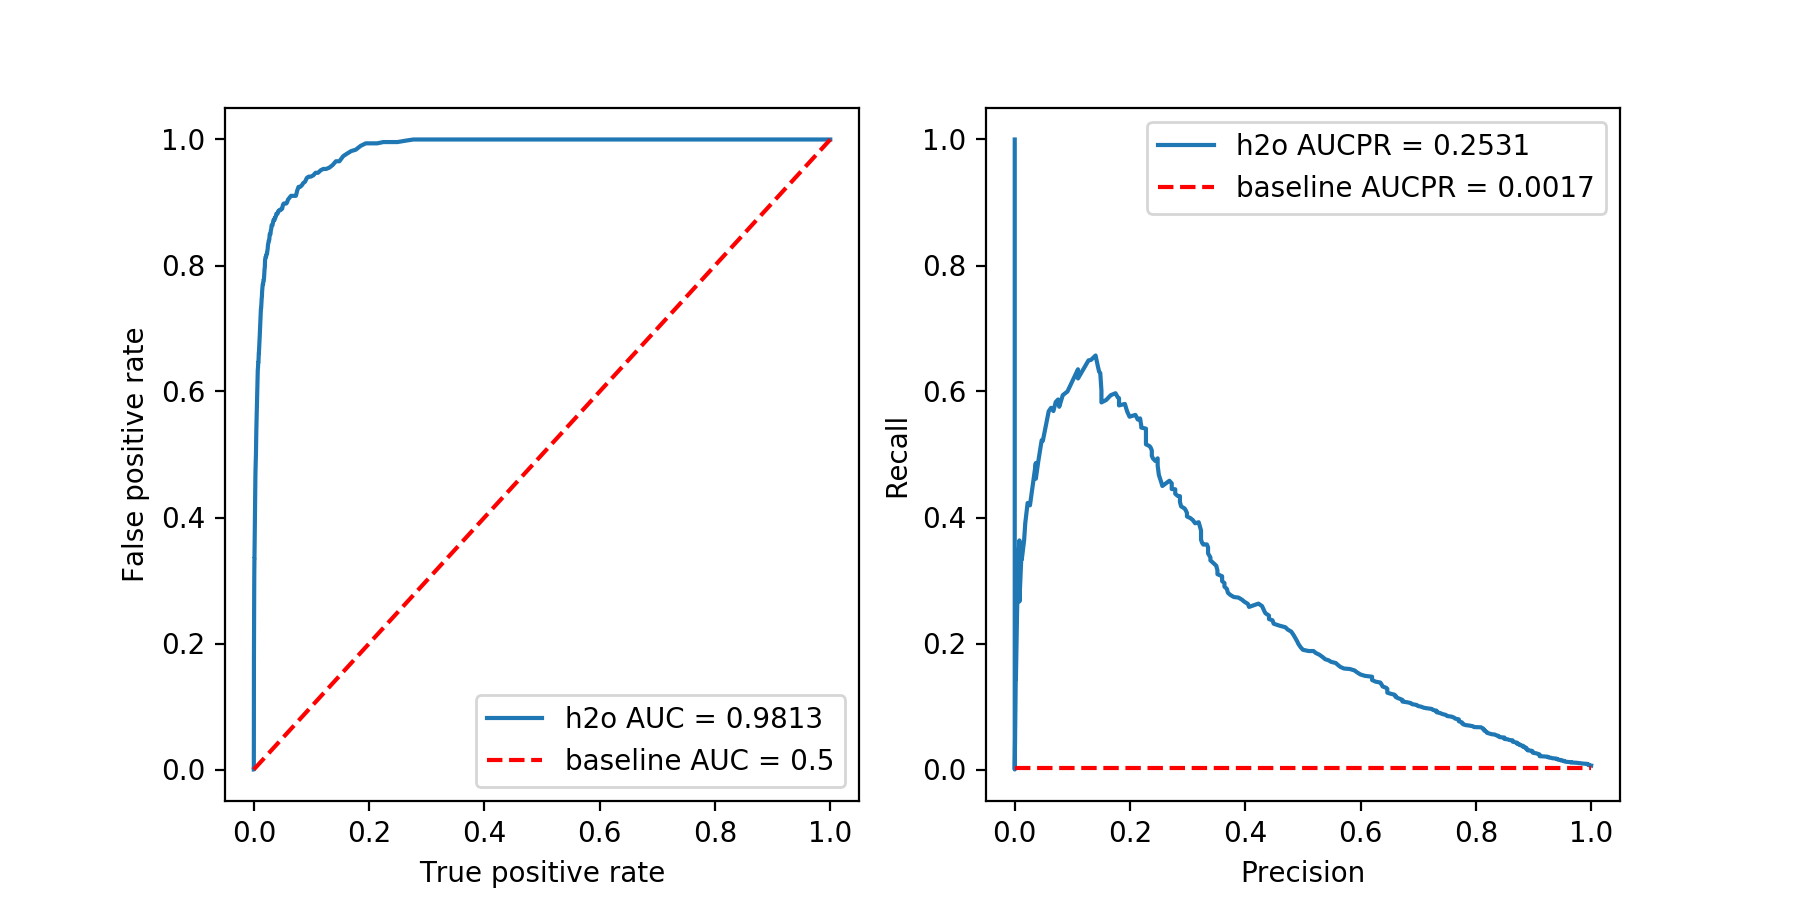

In [6]:
%matplotlib notebook
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np



def get_auc(labels, scores):
    fpr, tpr, thresholds = roc_curve(labels, scores)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score


def get_aucpr(labels, scores):
    precision, recall, th = precision_recall_curve(labels, scores)
    aucpr_score = np.trapz(recall, precision)
    return precision, recall, aucpr_score


def plot_metric(ax, x, y, x_label, y_label, plot_label, style="-"):
    ax.plot(x, y, style, label=plot_label)
    ax.legend()
    
    ax.set_ylabel(x_label)
    ax.set_xlabel(y_label)


def prediction_summary(labels, predicted_score, info, plot_baseline=True, axes=None):
    if axes is None:
        axes = [plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)]

    fpr, tpr, auc_score = get_auc(labels, predicted_score)
    plot_metric(axes[0], fpr, tpr, "False positive rate",
                "True positive rate", "{} AUC = {:.4f}".format(info, auc_score))
    if plot_baseline:
        plot_metric(axes[0], [0, 1], [0, 1], "False positive rate",
                "True positive rate", "baseline AUC = 0.5", "r--")

    precision, recall, aucpr_score = get_aucpr(labels, predicted_score)
    plot_metric(axes[1], recall, precision, "Recall",
                "Precision", "{} AUCPR = {:.4f}".format(info, aucpr_score))
    if plot_baseline:
        thr = sum(labels)/len(labels)
        plot_metric(axes[1], [0, 1], [thr, thr], "Recall",
                "Precision", "baseline AUCPR = {:.4f}".format(thr), "r--")

    plt.show()
    return axes


def figure():
    fig_size = 4.5
    f = plt.figure()
    f.set_figheight(fig_size)
    f.set_figwidth(fig_size*2)


h2o_predictions = predictions.as_data_frame()

figure()
axes = prediction_summary(
    h2o_predictions["class"], h2o_predictions["predict"], "h2o")

## Isolation Forests in scikit-learn

We can perform the same anomaly detection using scikit-learn. The version of the scikit-learn used in this example is 0.20. Some of the behavior can differ in other versions. The *score_samples* method returns the opposite of the anomaly score; therefore it is inverted. Scikit-learn also takes in a *contamination* parameter, which is the proportion of outliers in the data set.

In [7]:
from sklearn.ensemble import IsolationForest
import pandas as pd

df_pandas = df.as_data_frame()
df_train_pandas = df_pandas.iloc[:, :30]

x = IsolationForest(random_state=seed, contamination=(1-quantile),
                    n_estimators=ntrees, behaviour="new").fit(df_train_pandas)

iso_predictions = x.predict(df_train_pandas)
iso_score = x.score_samples(df_train_pandas)

sk_predictions = pd.DataFrame({
    "predicted_class": list(map(lambda x: 1*(x == -1), iso_predictions)),
    "class": h2o_predictions["class"],
    "predict": -iso_score
})

sk_predictions.head()

,predicted_class,class,predict
0,0,0,0.385838
1,0,0,0.371690
2,0,0,0.462719
3,0,0,0.414459
4,0,0,0.391178


## Evaluation of scikit-learn


<IPython.core.display.Javascript object>


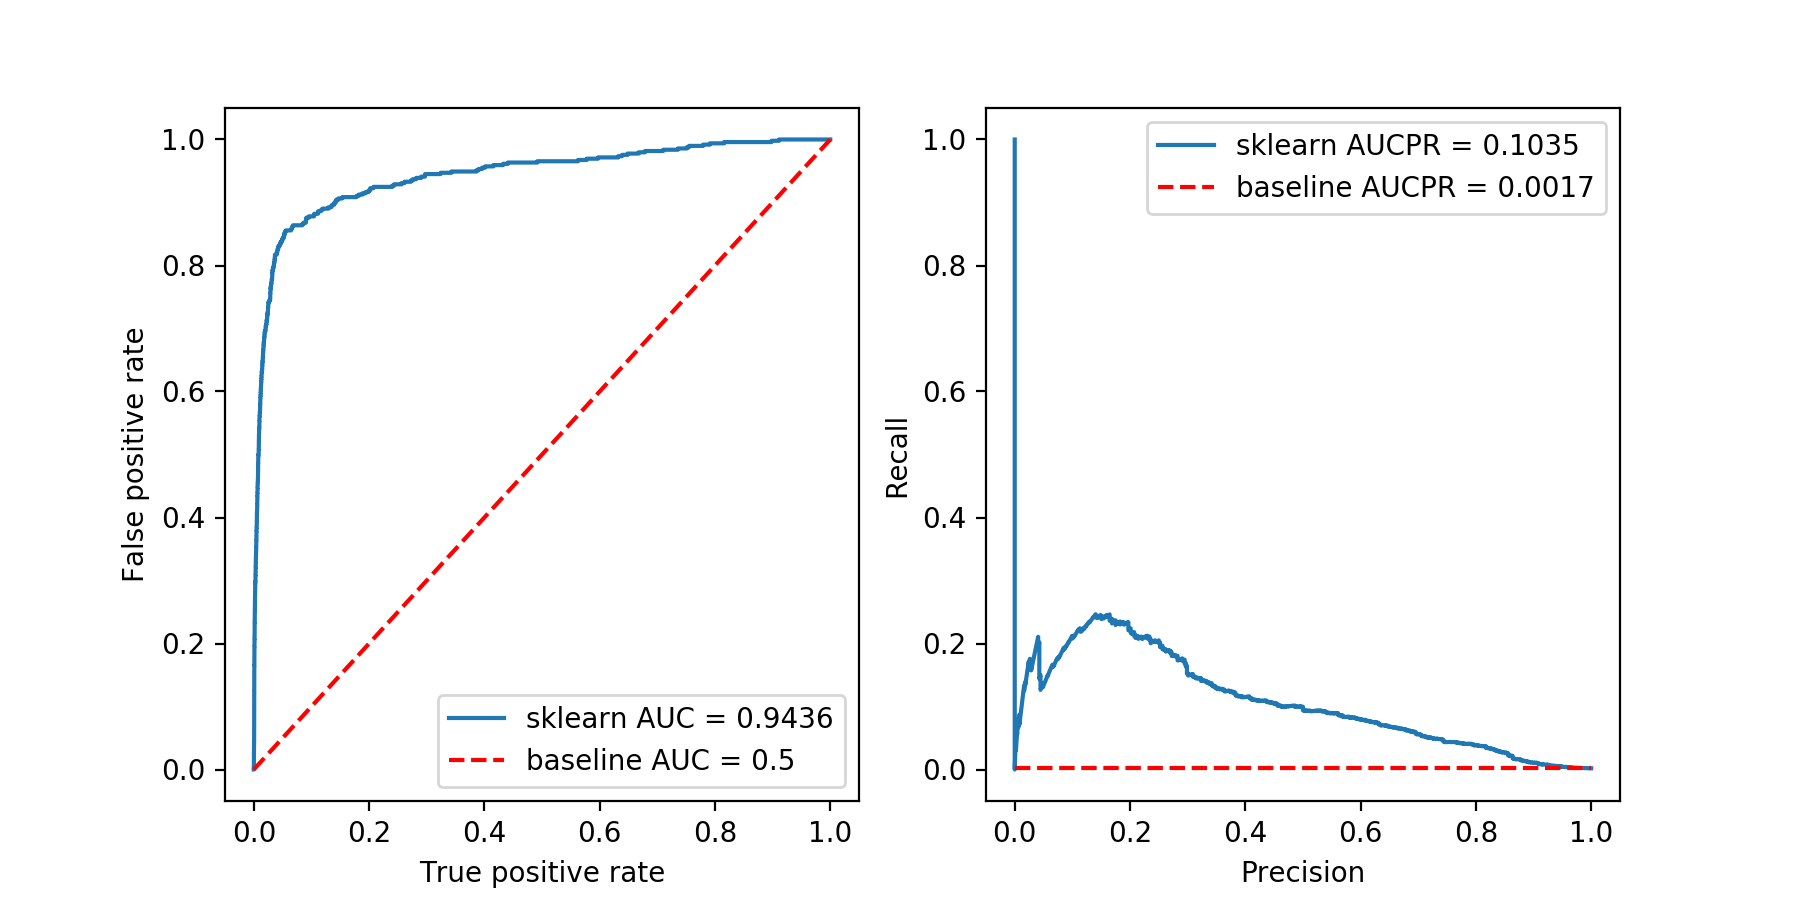

In [8]:
figure()
axes = prediction_summary(
    sk_predictions["class"], sk_predictions["predict"], "sklearn")

## Compare Isolation Forests

<IPython.core.display.Javascript object>


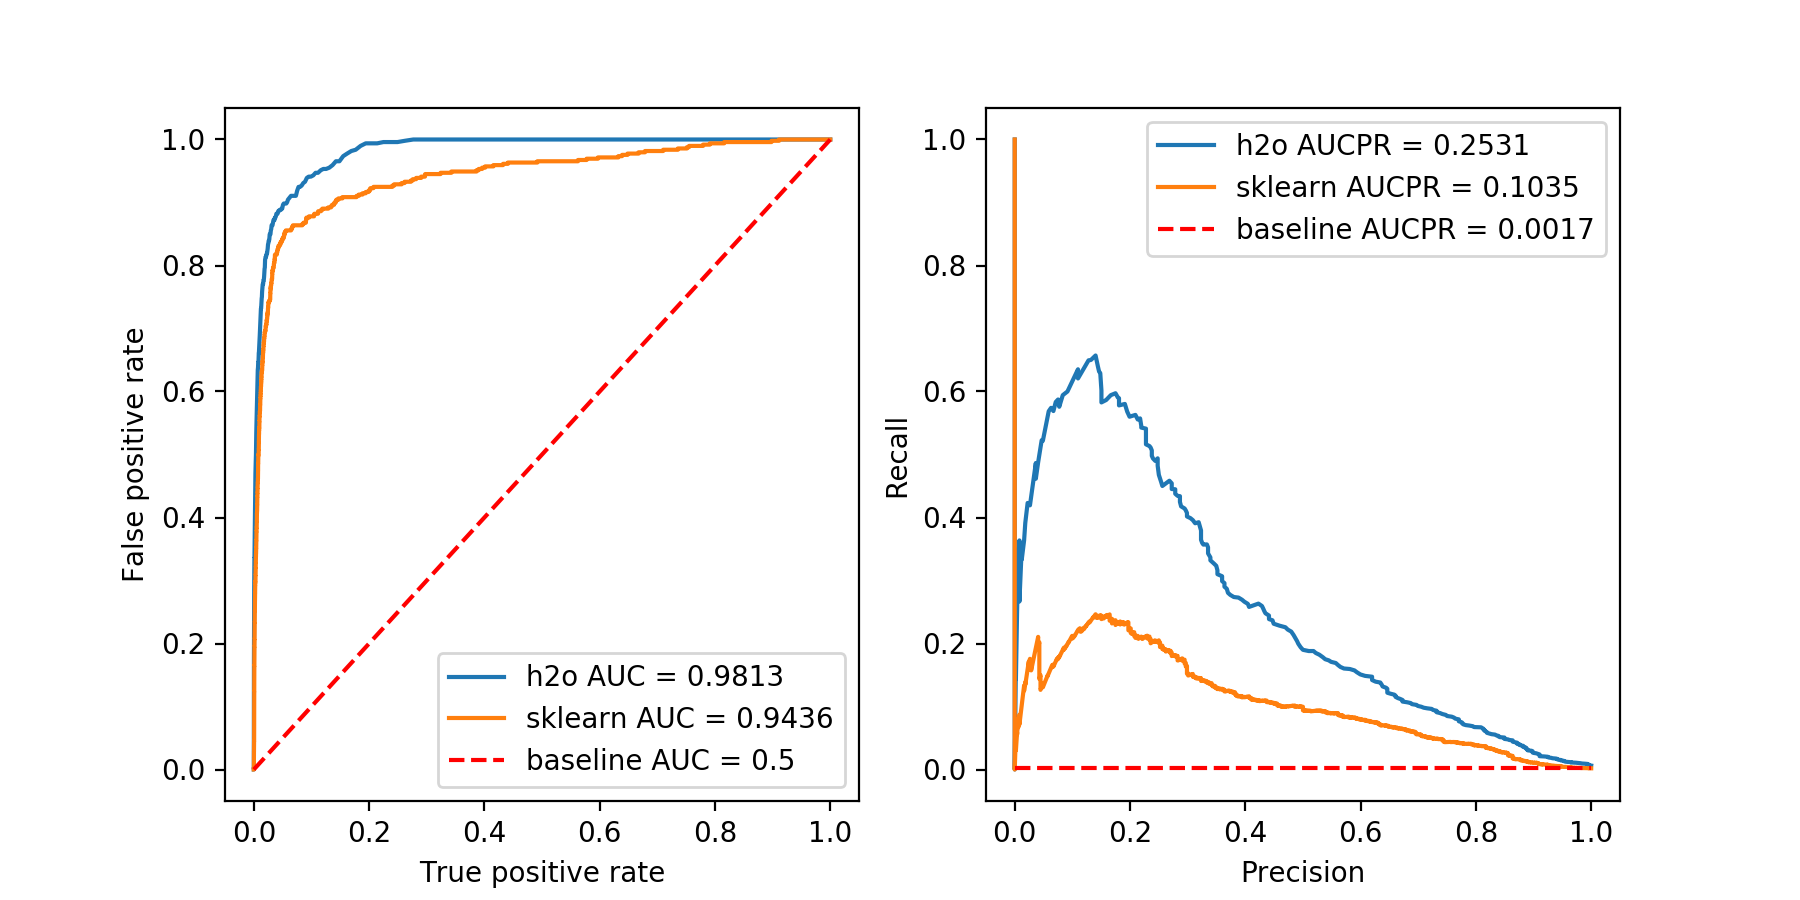

In [9]:
figure()
axes = prediction_summary(h2o_predictions["class"], h2o_predictions["predict"],
                        "h2o", plot_baseline=False)
axes = prediction_summary(sk_predictions["class"], sk_predictions["predict"],
                        "sklearn", axes=axes)

## More Robust Comparison

Because there is a lot of randomness in the isolation forests training, we will train the isolation forest 20 times for each library using different seeds, and then we will compare the statistics. While 20 times might not be enough, it could give us some insight into how the isolation forests perform on our anomaly detection task.

In [10]:
from tqdm import tqdm_notebook


def stability_check(train_predict_fn, x, y, ntimes=20):
    scores = ["AUC", "AUCPR"]
    scores = {key: [] for key in scores}
    seeds = np.linspace(1, (2**32) - 1, ntimes).astype(int)
    for seed in tqdm_notebook(seeds):
        predictions = train_predict_fn(x, int(seed))
        _, _, auc_score = get_auc(y, predictions)
        _, _, aucpr_score = get_aucpr(y, predictions)

        scores["AUC"].append(auc_score)
        scores["AUCPR"].append(aucpr_score)

    return pd.DataFrame(scores)


def iso_forests_h2o(data, seed):
    isoforest = h2o.estimators.H2OIsolationForestEstimator(
        ntrees=ntrees, seed=seed)
    isoforest.train(x=data.col_names, training_frame=data)
    preds = isoforest.predict(data)
    return preds.as_data_frame()["predict"]


def iso_forests_sklearn(data, seed):
    iso = IsolationForest(random_state=seed, n_estimators=ntrees,
                          behaviour="new", contamination=(1-quantile))
    iso.fit(data)
    iso_score = iso.score_samples(data)
    return -iso_score


h2o.no_progress()

h2o_check = stability_check(iso_forests_h2o, df[:30], h2o_predictions["class"])
sklearn_check = stability_check(
    iso_forests_sklearn, df_train_pandas, sk_predictions["class"])

sklearn_check.join(h2o_check, rsuffix="_h2o", lsuffix="_sklearn").describe()

,AUC_sklearn,AUCPR_sklearn,AUC_h2o,AUCPR_h2o
count,20.000000,20.000000,20.000000,20.000000
mean,0.948826,0.157122,0.946536,0.157575
std,0.003028,0.027204,0.004636,0.050624
min,0.941397,0.111953,0.935747,0.112319
25%,0.947779,0.133294,0.945074,0.119744
50%,0.949124,0.160745,0.947359,0.146700
75%,0.950789,0.171945,0.949958,0.160417
max,0.953361,0.206135,0.952723,0.302380


## Comparison Results

Looking at the results of the 20 runs, we can see that the h2o isolation forest implementation on average scores similarly to the scikit-learn implementation in both AUC and AUCPR. The big advantage of h2o is the ability to easily scale up to hundreds of nodes and work seamlessly with Apache Spark using Sparkling Water. This allows you to process extremely large datasets, which might be crucial in the transactional data setting.


## Conclusion

We have learned about the isolation forests, their underlying principle, how to apply them for unsupervised anomaly detection, and how to evaluate the quality of anomaly detection once we have corresponding labels. Even though we did not go deep into internal parameters of the isolation forest algorithm, you should now be able to apply it to any anomaly detection task you might face. I hope you have enjoyed this journey as much as I did.